In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import gradio as gr
from sklearn.preprocessing import MinMaxScaler

In [3]:
def geocode_city(city_name: str):

    url = "https://geocoding-api.open-meteo.com/v1/search"
    params = {"name": city_name, "count": 1, "language": "en"}
    r = requests.get(url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()
    if not data.get("results"):
        raise ValueError("City not found. Try 'Penang', 'Singapore', 'London', etc.")
    res = data["results"][0]
    return {
        "label": f"{res['name']}, {res.get('country_code','')}".strip(", "),
        "lat": res["latitude"],
        "lon": res["longitude"],
        "timezone": res.get("timezone", "auto"),
    }

In [4]:
geocode_city("Penang")

{'label': 'Penang, MY',
 'lat': 5.37292,
 'lon': 100.24963,
 'timezone': 'Asia/Kuala_Lumpur'}

In [5]:
latitude =  list(geocode_city("Penang").values())[1]
latitude


5.37292

In [6]:
#Get the longitude value
longitude = list(geocode_city("Kuala Lumpur").values())[2]
longitude

101.68653

In [7]:
#Get the timezone
timezone = list(geocode_city("Kuala Lumpur").values())[3]
timezone

'Asia/Kuala_Lumpur'

In [8]:
# Fetching Hourly Temprature
def fetch_hourly_temperature(lat: float, lon: float, timezone="auto", past_days=7):
    """
    Get recent hourly temperature (Celsius) for the last few days.
    No API key needed.
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",
        "past_days": past_days,
        "forecast_days": 1,      # include today
        "timezone": timezone,
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()
    times = js["hourly"]["time"]
    temps = js["hourly"]["temperature_2m"]
    df = pd.DataFrame({"time": pd.to_datetime(times), "temp": temps}).dropna()
    return df.reset_index(drop=True)

In [9]:
# dataframe
df = fetch_hourly_temperature(latitude,longitude,timezone)

df

,time,temp
0,2025-09-06 00:00:00,22.5
1,2025-09-06 01:00:00,22.2
2,2025-09-06 02:00:00,22.0
3,2025-09-06 03:00:00,21.8
4,2025-09-06 04:00:00,21.6
...,...,...
187,2025-09-13 19:00:00,24.8
188,2025-09-13 20:00:00,24.0
189,2025-09-13 21:00:00,23.6
190,2025-09-13 22:00:00,23.4


Text(0, 0.5, 'Temperature')

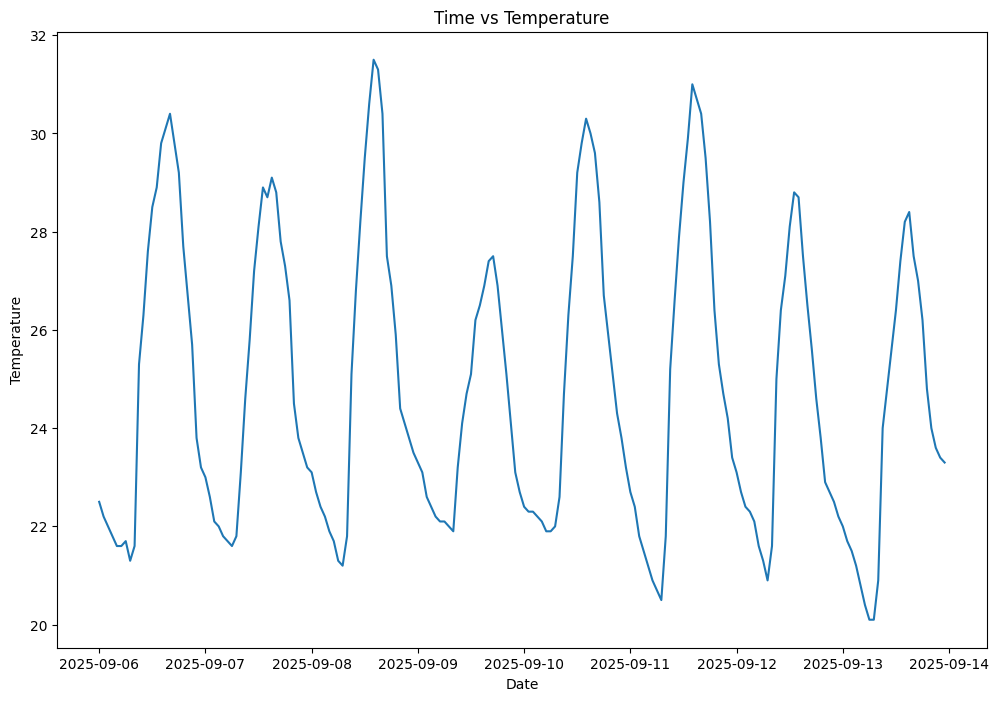

In [10]:
#visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(df['time'],df['temp'])
plt.title('Time vs Temperature')
plt.xlabel('Date')
plt.ylabel("Temperature")


In [11]:
def make_windows(series: np.ndarray, window: int = 24):

    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    X = np.array(X, dtype="float32")[..., np.newaxis]
    y = np.array(y, dtype="float32")
    return X, y

In [12]:
X,y = make_windows(df['temp'].values)

In [14]:
X


array([[[22.5],
        [22.2],
        [22. ],
        ...,
        [25.7],
        [23.8],
        [23.2]],

       [[22.2],
        [22. ],
        [21.8],
        ...,
        [23.8],
        [23.2],
        [23. ]],

       [[22. ],
        [21.8],
        [21.6],
        ...,
        [23.2],
        [23. ],
        [22.6]],

       ...,

       [[22.7],
        [22.5],
        [22.2],
        ...,
        [26.2],
        [24.8],
        [24. ]],

       [[22.5],
        [22.2],
        [22. ],
        ...,
        [24.8],
        [24. ],
        [23.6]],

       [[22.2],
        [22. ],
        [21.7],
        ...,
        [24. ],
        [23.6],
        [23.4]]], dtype=float32)

In [17]:
y

array([23. , 22.6, 22.1, 22. , 21.8, 21.7, 21.6, 21.8, 23.1, 24.6, 25.8,
       27.2, 28.1, 28.9, 28.7, 29.1, 28.8, 27.8, 27.3, 26.6, 24.5, 23.8,
       23.5, 23.2, 23.1, 22.7, 22.4, 22.2, 21.9, 21.7, 21.3, 21.2, 21.8,
       25.1, 26.8, 28.2, 29.5, 30.6, 31.5, 31.3, 30.4, 27.5, 26.9, 25.9,
       24.4, 24.1, 23.8, 23.5, 23.3, 23.1, 22.6, 22.4, 22.2, 22.1, 22.1,
       22. , 21.9, 23.2, 24.1, 24.7, 25.1, 26.2, 26.5, 26.9, 27.4, 27.5,
       26.9, 26. , 25.1, 24.1, 23.1, 22.7, 22.4, 22.3, 22.3, 22.2, 22.1,
       21.9, 21.9, 22. , 22.6, 24.7, 26.3, 27.5, 29.2, 29.8, 30.3, 30. ,
       29.6, 28.6, 26.7, 25.9, 25.1, 24.3, 23.8, 23.2, 22.7, 22.4, 21.8,
       21.5, 21.2, 20.9, 20.7, 20.5, 21.8, 25.2, 26.6, 27.9, 29. , 29.9,
       31. , 30.7, 30.4, 29.5, 28.2, 26.4, 25.3, 24.7, 24.2, 23.4, 23.1,
       22.7, 22.4, 22.3, 22.1, 21.6, 21.3, 20.9, 21.6, 25. , 26.4, 27.1,
       28.1, 28.8, 28.7, 27.5, 26.5, 25.6, 24.6, 23.8, 22.9, 22.7, 22.5,
       22.2, 22. , 21.7, 21.5, 21.2, 20.8, 20.4, 20

In [18]:
def build_lstm(window=24):

  model = keras.Sequential([
      layers.Input(shape=(window,1)),#(window,1)-> Indicates the input dimension which is (24,1)
      layers.LSTM(32),#32 memory cells
      layers.Dense(1),#Output which is 1 prediction at a time
  ])
  model.compile(optimizer='adam',loss='mse')
  return model

In [23]:

#Temperature value is what we are predicting
#Window we set 24 for 24 hours timeframe
#epoch we set 3 for 3 training itteration ,you can set more
#Next step is for the next 6 hours of prediction after the current hour


def train_and_forcast(temp_values,window=24,epochs=3,next_step = 6):

  vals = temp_values.reshape(-1,1)#We need to reshape this in 2D so that we can apply min max scaling to the data

  #Implement the min max scaling
  scaler = MinMaxScaler()
  vals_scaled = scaler.fit_transform(vals)

  #Make the (X,y) sequence -> Since LSTM is a supervised we need to define the input sequence and the output of the sequence
  #we use the make_windows() function to create the sequence
  #This is required for LSTM

  X,y = make_windows(vals_scaled,window=window)

  #Build the model -> Use Build LSTM function created above
  model = build_lstm(window)
  model.fit(X,y,epochs=epochs,batch_size=32,verbose=0)

  #When we do the pridiction we need to ensure we are doing it based on the the current 24 hour(Current day) to the next 6 hours or more
  #In this case we index the last 24 hours window
  last_window = vals_scaled[-window:].copy()#Get the current 24 hours of data(Current day data )
  pred_scale = []#We create an empty list to store the predicted output based on the models prediction , in simple words we are going to store the predicted values in the list

  #If we were to predict the next 6 hours of temperature data, the model should produce 6 predicted temperature data
  #In order for us to get the 6 tem data we need to itterate the model to predict 6 times or more
  #In this case we use for loop

  for _ in range(next_step):
    pred = model.predict(last_window.reshape(1,window,1),verbose=0)[0,0]
    #(1,window,1)-> (1 = batch size,window = number of time steps,1=one feature per time step[temperature only])
    #[0,0] -> extract the prediction out of the 2D results
    pred_scale.append(pred)#Pupulate the prediction into the list
    #We want to focus on the current 24 hours window and the prediction
    last_window= np.append(last_window[1:],pred)#last_window[1:]-> Drops the oldest value from the sequence,add new prediction at the end

  #Revert he min max scaled data to the original data to visualize the accual output
  preds = scaler.inverse_transform(np.array(pred_scale).reshape(-1,1)).flatten()

  return preds




In [24]:
#Check the prediction

train_and_forcast(df['temp'].values)#Return all the predicted values

array([25.394457, 25.432735, 25.485878, 25.547913, 25.6157  , 25.687244],
      dtype=float32)